In [1]:
import igrf13
from datetime import datetime

%matplotlib notebook
import matplotlib.pyplot as plt


In [2]:
datetime.today()

datetime.datetime(2020, 5, 27, 9, 13, 1, 231131)

In [3]:
altitudes_km = np.arange(150, 300, 1)

mag = igrf13.igrf(datetime.today(), glat=65, glon=-148, alt_km=altitudes_km, model=13, )
mag

<xarray.Dataset>
Dimensions:  (alt_km: 150)
Coordinates:
  * alt_km   (alt_km) int64 150 151 152 153 154 155 ... 294 295 296 297 298 299
Data variables:
    north    (alt_km) float64 1.124e+04 1.123e+04 ... 1.054e+04 1.053e+04
    east     (alt_km) float64 3.298e+03 3.296e+03 ... 3.026e+03 3.024e+03
    down     (alt_km) float64 5.14e+04 5.137e+04 ... 4.806e+04 4.804e+04
    total    (alt_km) float64 5.271e+04 5.269e+04 ... 4.929e+04 4.927e+04
    incl     (alt_km) float64 77.16 77.16 77.16 77.16 ... 77.15 77.15 77.15
    decl     (alt_km) float64 16.36 16.35 16.35 16.35 ... 16.02 16.02 16.02

<IPython.core.display.Javascript object>


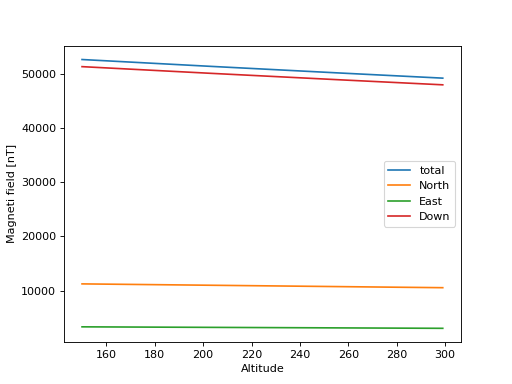

Text(0, 0.5, 'Magneti field [nT]')

In [4]:
plt.figure()
plt.plot(mag.alt_km, mag.total , label="total")
plt.plot(mag.alt_km, mag.north , label="North")
plt.plot(mag.alt_km, mag.east , label="East")
plt.plot(mag.alt_km, mag.down , label="Down")

plt.legend()
plt.xlabel("Altitude")
plt.ylabel("Magneti field [nT]")

# Magnetic field over an orbit

It can be useful to know the the magnetif field during the orbit of the satellite.

In [27]:
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from astropy import units as u
from astropy import time

from astropy.coordinates import ( SkyCoord,
    GCRS,
    ITRS,
    CartesianRepresentation,
    SphericalRepresentation,
)


epoch = time.Time("2020-05-25 12:00")  # UTC by default

In [6]:
# Data from Curtis, example 4.3
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

orb = Orbit.from_vectors(Earth, r, v, epoch)

long, lat, alt = orb.L, orb.arglat, np.linalg.norm(orb.r) - Earth.R
print(f"longitude {long.to(u.deg):2.2f}, latitude {lat.to(u.deg):2.2f}, altitude {alt.to(u.km):2.2f} ")

mag = igrf13.igrf(epoch.datetime, glat=lat.to(u.deg).value, glon=long.to(u.deg).value, alt_km=alt.to(u.km).value, model=13, )
mag

longitude 303.79 deg, latitude 48.51 deg, altitude 1036.18 km 


<xarray.Dataset>
Dimensions:  (alt_km: 1)
Coordinates:
  * alt_km   (alt_km) float64 1.036e+03
Data variables:
    north    (alt_km) float64 1.157e+04
    east     (alt_km) float64 -3.193e+03
    down     (alt_km) float64 3.038e+04
    total    (alt_km) float64 3.266e+04
    incl     (alt_km) float64 68.43
    decl     (alt_km) float64 -15.42

In [15]:
orb_10m = orb.propagate(3 * u.min)
orb_10m

7283 x 10293 km x 153.2 deg (GCRS) orbit around Earth (♁) at epoch 2020-05-25 12:03:00.000 (UTC)

In [24]:
orb_10m.get_frame()
orb_10m

7283 x 10293 km x 153.2 deg (GCRS) orbit around Earth (♁) at epoch 2020-05-25 12:03:00.000 (UTC)

In [37]:
orb_10m.r.value

array([-6569.90980869, -2250.55198062,  2914.65523059])

In [44]:
orb_itrs = SkyCoord([orb_10m.r], frame="gcrs", representation_type='cartesian').transform_to(ITRS)

# Converting into lat and lon
orb_itrs.represent_as(SphericalRepresentation)

<SphericalRepresentation (lon, lat, distance) in (rad, rad, km)
    [(4.86449023, 0.39740193, 7531.52801395)]>

## along an orbit

In [48]:
times = epoch + orb.period * np.linspace(0, 1, 100)
orb_postions = orb.propagate(times)

orb_itrs = SkyCoord(orb_postions.r, frame="gcrs", representation_type='cartesian').transform_to(ITRS)

# Converting into lat and lon
orb_itrs.represent_as(SphericalRepresentation)

ValueError: One or more elements of input sequence does not have a length

<IPython.core.display.Javascript object>


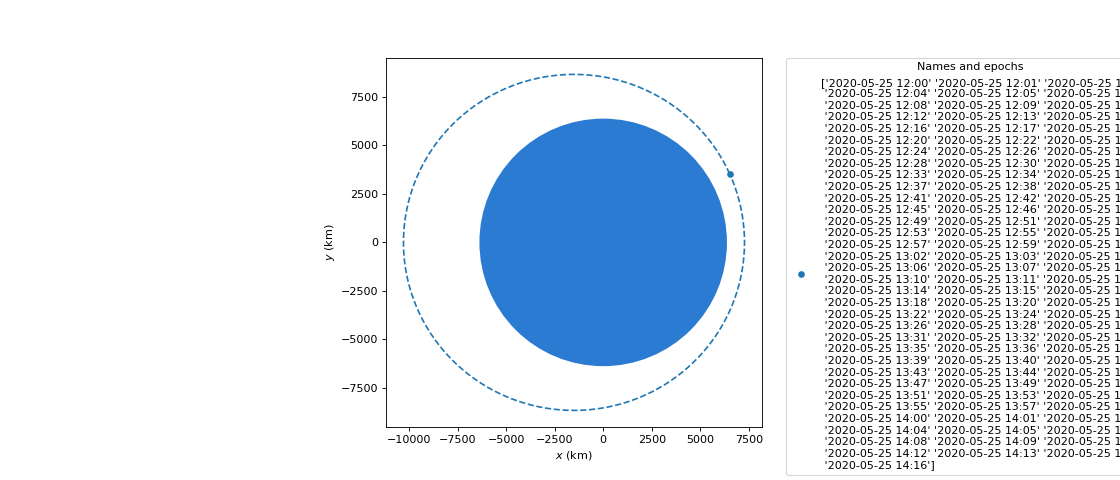

In [54]:
orb_postions.plot()

In [59]:
from poliastro.twobody.propagation import propagate

In [64]:
positions = propagate(orb, times - epoch)


In [65]:
orb_itrs = SkyCoord(positions, frame="gcrs", representation_type='cartesian').transform_to(ITRS)

# Converting into lat and lon
orb_itrs.represent_as(SphericalRepresentation)

<SphericalRepresentation (lon, lat, distance) in (rad, rad, km)
    [(5.05805576e+00,  0.34396114,  7414.31891681),
     (4.96924896e+00,  0.37033096,  7464.15251005),
     (4.87999970e+00,  0.39367249,  7520.99223956),
     (4.79056688e+00,  0.41383984,  7584.3160713 ),
     (4.70124473e+00,  0.4307427 ,  7653.56698477),
     (4.61235154e+00,  0.44434676,  7728.16407335),
     (4.52421622e+00,  0.45467189,  7807.51292498),
     (4.43716387e+00,  0.46178797,  7891.0150033 ),
     (4.35150179e+00,  0.46580904,  7978.07585013),
     (4.26750727e+00,  0.46688589,  8068.11202297),
     (4.18541810e+00,  0.46519795,  8160.55675919),
     (4.10542642e+00,  0.46094492,  8254.86441828),
     (4.02767600e+00,  0.45433879,  8350.51379735),
     (3.95226259e+00,  0.44559665,  8447.01044144),
     (3.87923677e+00,  0.43493447,  8543.88808323),
     (3.80860854e+00,  0.4225622 ,  8640.70935029),
     (3.74035303e+00,  0.40868002,  8737.0658718 ),
     (3.67441653e+00,  0.39347574,  8832.57790824),


In [66]:
# Converting into lat and lon
orb_sperical = orb_itrs.represent_as(SphericalRepresentation)

In [68]:
orb_sperical.lat.to(u.deg)

<Latitude [ 19.70752168,  21.2184009 ,  22.5557722 ,  23.71127631,
            24.67973863,  25.45919422,  26.05078011,  26.45850179,
            26.68889221,  26.75059128,  26.65387918,  26.41019836,
            26.03169539,  25.53080738,  24.91990932,  24.21103046,
            23.41564027,  22.5444995 ,  21.60756812,  20.61396032,
            19.57193667,  18.48892381,  17.37155363,  16.22571514,
            15.05661353,  13.86883258,  12.66639725,  11.45283464,
            10.23123181,   9.00428986,   7.77437381,   6.54355823,
             5.31366866,   4.08631926,   2.8629467 ,   1.64484086,
             0.43317275,  -0.77098029,  -1.96661137,  -3.15276272,
            -4.3285059 ,  -5.49292317,  -6.64508981,  -7.78405717,
            -8.90883616, -10.01838099, -11.11157305, -12.18720468,
           -13.24396275, -14.28041194, -15.29497762, -16.28592841,
           -17.25135828, -18.18916838, -19.09704872, -19.97245993,
           -20.81261538, -21.61446422, -22.37467578, -23.08962

In [70]:
orb_sperical.lon.to(u.deg)

<Longitude [2.89805248e+02, 2.84716993e+02, 2.79603387e+02, 2.74479264e+02,
            2.69361481e+02, 2.64268277e+02, 2.59218495e+02, 2.54230763e+02,
            2.49322687e+02, 2.44510156e+02, 2.39806793e+02, 2.35223607e+02,
            2.30768836e+02, 2.26447966e+02, 2.22263894e+02, 2.18217195e+02,
            2.14306442e+02, 2.10528559e+02, 2.06879160e+02, 2.03352867e+02,
            1.99943593e+02, 1.96644779e+02, 1.93449595e+02, 1.90351091e+02,
            1.87342323e+02, 1.84416442e+02, 1.81566755e+02, 1.78786772e+02,
            1.76070229e+02, 1.73411104e+02, 1.70803621e+02, 1.68242242e+02,
            1.65721660e+02, 1.63236788e+02, 1.60782740e+02, 1.58354815e+02,
            1.55948478e+02, 1.53559342e+02, 1.51183152e+02, 1.48815762e+02,
            1.46453121e+02, 1.44091254e+02, 1.41726250e+02, 1.39354242e+02,
            1.36971397e+02, 1.34573904e+02, 1.32157961e+02, 1.29719768e+02,
            1.27255518e+02, 1.24761397e+02, 1.22233575e+02, 1.19668214e+02,
            

<IPython.core.display.Javascript object>


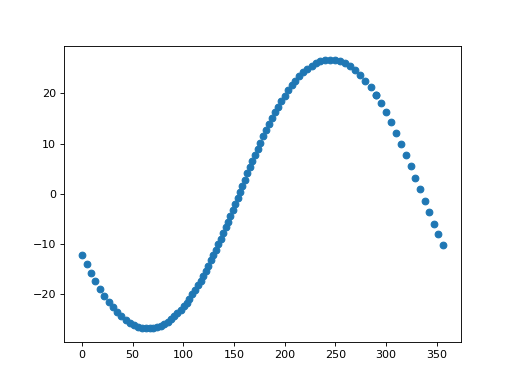

In [73]:
plt.figure()
plt.scatter(orb_sperical.lon.to(u.deg), orb_sperical.lat.to(u.deg), )